# Install Dependencies on Colab

In [0]:
!pip install kaggle

# Import dependencies

In [0]:
import numpy as np
import pandas as pd
import torchvision
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline

# Upload the train.csv and test.csv

In [0]:
files.upload()

## In case you want to download train and test csv direct to colab (Optional)

In [0]:
!mv kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c digit-recognizer

# Dataset and Dataloaders

In [0]:
class DatasetMNIST():
    
    def __init__(self, file_path, dataset=False, transform=None, test=False):
        if(file_path==False):
          self.data = dataset.as_matrix()
        elif(dataset==False):
          self.data = pd.read_csv(file_path).as_matrix()
        else:
          raise Exception('Dataset input ambiguous.')
        self.transform = transform
        self.test = test
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        if(not self.test):
          image = (self.data[index, 1:]).astype(np.uint8).reshape((28, 28))
          label = self.data[index, 0]
        else:
          image = (self.data[index, :]).astype(np.uint8).reshape((28, 28))
          label = np.nan
        
        image = Image.fromarray(image, mode='L')
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

### Load train dataset and split it for cross validation

In [0]:
train_set_orig = pd.read_csv("train.csv")

In [0]:
X = train_set_orig
y = train_set_orig['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Transforms

In [0]:
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.ToTensor()
    ])
test_transform = transforms.ToTensor()

### Train and Test loaders

In [0]:
trainloader = DatasetMNIST(False, X_train, transform)
trainloader = torch.utils.data.DataLoader(trainloader, batch_size=64, shuffle=True)

In [0]:
testloader = DatasetMNIST(False, X_test, test_transform)
testloader = torch.utils.data.DataLoader(testloader, batch_size=64, shuffle=True)

### Check the sample training photo

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


tensor(4)


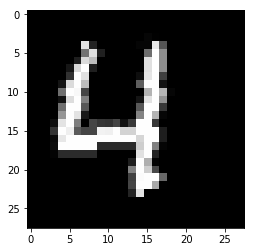

In [95]:
images, labels = next(iter(trainloader))

image = images[0].squeeze()

print(labels[0])
plt.imshow(image, cmap='gray')
plt.grid('False')

# Training

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Neural network architecture

In [ ]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 28x28x3 image tensor)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv11 = nn.Conv2d(32, 32, 3, padding=1)
        # convolutional layer (sees 14x14x32 tensor)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv21 = nn.Conv2d(64, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 7 * 7, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.LogSoftmax(dim=1)
        self.norm = nn.BatchNorm1d(500)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv11(F.relu(self.conv1(x)))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv21(F.relu(self.conv2(x)))))
        x = self.dropout(x)
        # flatten image input
        x = x.view(-1, 64 * 7 * 7)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.norm(x)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        x = self.output(x)
        return x

# create a complete CNN
model = Net()

# move tensors to GPU if CUDA is available
model.to(device)

## Optimizer, Loss, Scheduler

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1)

## Training Loop

In [0]:
# number of epochs to train the model
n_epochs = 30


valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(testloader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(testloader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss
        
        
    scheduler.step(valid_loss)

# Testing model

## Load the best model

In [101]:
model.load_state_dict(torch.load('model_augmented.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Check the loss accuracy per class

In [102]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
batch_size = 16
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in testloader:
  
    data, target = data.to('cuda'), target.to('cuda')
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.016874

Test Accuracy of     0: 100% (207/207)
Test Accuracy of     1: 100% (224/224)
Test Accuracy of     2: 99% (229/231)
Test Accuracy of     3: 99% (210/211)
Test Accuracy of     4: 99% (201/202)
Test Accuracy of     5: 100% (169/169)
Test Accuracy of     6: 100% (219/219)
Test Accuracy of     7: 99% (230/231)
Test Accuracy of     8: 99% (215/217)
Test Accuracy of     9: 100% (201/201)

Test Accuracy (Overall): 99% (2105/2112)


## Printing the photos with their predictions to get intuition

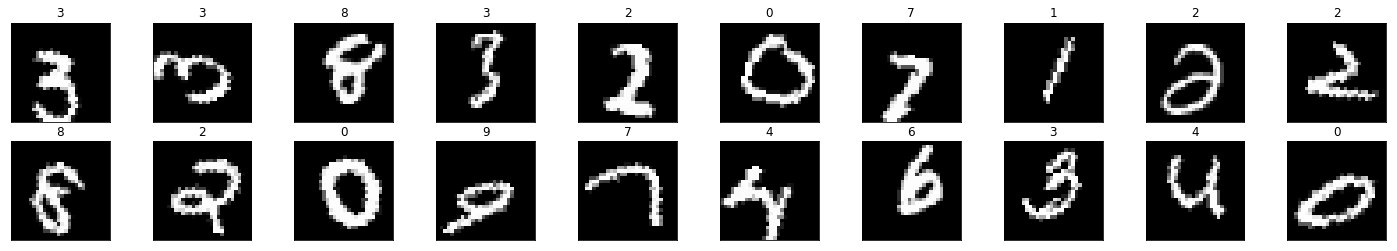

In [103]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Generating the test results

## Read test dataset

In [0]:
test_set = pd.read_csv("test.csv")

## Dataloader for test.csv

In [0]:
finalloader = DatasetMNIST(False, dataset=test_set, transform=test_transform, test=True)
finalloader = torch.utils.data.DataLoader(finalloader, batch_size=64, shuffle=False)

## Getting predictions

In [ ]:
model.eval() # prep model for evaluation

predictions = []

for data, target in finalloader:
  
    data, target = data.to('cuda'), target.to('cuda')
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    predictions.append(top_class)
model.train()

In [0]:
predictions = [i.to('cpu').numpy().tolist() for i in predictions]
predictions = [j for sub in predictions for j in sub]
predictions = [j for sub in predictions for j in sub]

In [0]:
test_set.insert(loc=0, column='Label', value=predictions)

In [111]:
test_set.head()

,Label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Printing predictions with the photos in test.csv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


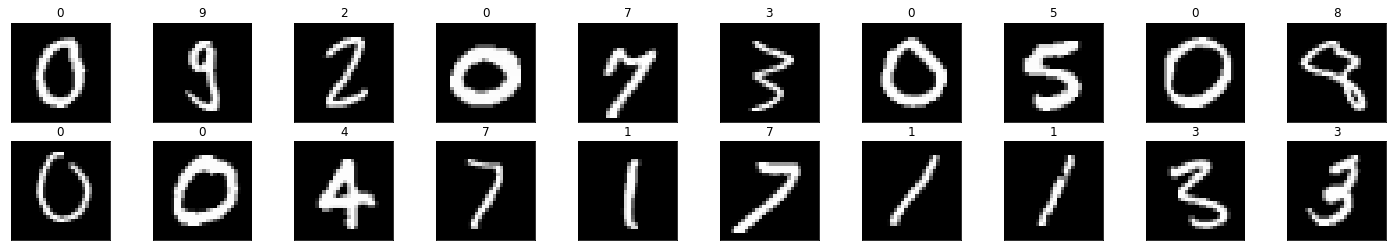

In [112]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(100,120):
    image = test_set.as_matrix()[idx, 1:].reshape(28,28)
    ax = fig.add_subplot(2, 20/2, idx-99, xticks=[], yticks=[])
    ax.imshow(np.squeeze(image), cmap='gray')
    ax.set_title(str(predictions[idx]))
    

## Generating final dataset

In [0]:
df = pd.DataFrame({'ImageId':[x+1 for x in range(28000)], 'Label':predictions})

In [114]:
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


## Saving results and downloading

In [0]:
df.to_csv('submission.csv', index=False)

In [0]:
files.download('submission.csv')